# Cointegration Testing:
1. Retrieves data from yahoo finance API
2. Uses yahooquery's Screener() class to request assets from yfinance related to a specific industry

In [2]:
import yfinance as yf
from yahooquery import Screener
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import coint, adfuller
import numpy as np
import itertools
import math

In [41]:
# The below instantiates an instance of the Screener class and returns all available screeners.
# For testing sake, the first 10 screeners returned are of interest
# Can specify filters for the screener by passing in ['most_actives','day_gainers', *count] as a parameter to 
# s.get_screeners(['most_actives', 'day_gainers'], 5) which returns a dictionary/JSON
NUMBER_ASSETS_TO_DOWNLOAD = 200
screener = Screener()
industries = screener.available_screeners
print("Number of industries returned by screener: ",len(industries))
selection = industries

industry = 'information_technology_services'
stocks = selection[selection.index(industry)]
# returns assets in the stocks industry
stocks_info = screener.get_screeners(stocks, count=NUMBER_ASSETS_TO_DOWNLOAD)
assets = stocks_info[industry]['quotes']
symbols = []
for asset in assets:
    symbols.append(asset['symbol'])
# Symbols now contains all the 'tickers' of the assets we selected by industry, stocks
selection
symbols

Number of industries returned by screener:  383


['ACN',
 'IBM',
 'FI',
 'INFY',
 'FIS',
 'IT',
 'CTSH',
 'WIT',
 'LDOS',
 'BR',
 'CDW',
 'GIB',
 'EPAM',
 'JKHY',
 'CACI',
 'PSN',
 'GLOB',
 'AUR',
 'G',
 'SAIC',
 'EXLS',
 'KD',
 'INGM',
 'ASGN',
 'DXC',
 'CNXC',
 'WNS',
 'VYX',
 'NABL',
 'APLD',
 'TASK',
 'FORTY',
 'XRX',
 'NYAX',
 'PENG',
 'HCKT',
 'DMRC',
 'CTLP',
 'UIS',
 'MGIC']

### Other useful functions from yahooquery API, functionality is self explanatory:
1. import yahooquery as yq
   data = yq.get_currencies()

2. yq.get_market_summary(country='hong kong')
3. data = yq.search(ticker), other optional parameters = [query,quotes_count,news_count,first_quote,country]

Information source: https://yahooquery.dpguthrie.com/guide/misc/

In [83]:
# The following extracts data for the assets selected in industries array, and requests it's
# historic data from the yfinance API (Which has more functionality per asset that just offering historic data)

# Dictionary storing data, in the form of a pandas DataFrame, for every asset in 'symbols' array

industry_data_dict = {}

def retrieveData(asset: str, period: str):
    data = yf.Ticker(asset)
    return data.history(period=period)
symbols = ['AAPL','META','AMZN','GOOG','NVDA','NFLX']
NUMBER_ASSETS_TO_USE = len(symbols)-1
#Choosing the first 10 to prevent rate limiting while testing
# Making the period "1mo" while testing, can request "10y" and "max"
for asset in symbols[:NUMBER_ASSETS_TO_USE]:
    industry_data_dict[asset] = retrieveData(asset,"2y")

# A potentially much better way of downloading the data is:
# data = yf.download(symbols, start_date, end_date)['Adj Close']
# Which returns a neat dataframe where the columns are the assets and rows the historic 

industry_data_dict
# min_length = 1259
# for (key,dataframe) in industry_data_dict.items():
#     if len(dataframe)<min_length:
#         min_length=len(dataframe)

# for (key,dataframe) in industry_data_dict.items():
#     dataframe[:min_length]
# print(min_length)


{'AAPL':                                  Open        High         Low       Close  \
 Date                                                                        
 2022-11-14 00:00:00-05:00  147.419760  148.716126  145.895778  146.736938   
 2022-11-15 00:00:00-05:00  150.635929  151.991667  147.014013  148.478607   
 2022-11-16 00:00:00-05:00  147.578081  148.310370  145.757217  147.241608   
 2022-11-17 00:00:00-05:00  144.906185  149.903636  144.629100  149.151550   
 2022-11-18 00:00:00-05:00  150.724996  151.110937  148.409351  149.715607   
 ...                               ...         ...         ...         ...   
 2024-11-06 00:00:00-05:00  222.365355  225.821559  220.946918  222.475235   
 2024-11-07 00:00:00-05:00  224.383137  227.629565  224.323205  227.229996   
 2024-11-08 00:00:00-05:00  227.169998  228.660004  226.410004  226.960007   
 2024-11-11 00:00:00-05:00  225.000000  225.699997  221.500000  224.229996   
 2024-11-12 00:00:00-05:00  224.630005  225.470001  223.

In [84]:
# function for retrieving timestamps of data in desired format for plotting

def get_timestamps(symbol:str):
    return list(map(lambda x: x.split(' ')[0] ,industry_data_dict[symbol].index.strftime('%Y-%m-%d %H:%M:%S').tolist()))

# get_timestamps('BTC-USD')

Some of the below code has been adapted from:
https://medium.com/@TejasEkawade/time-series-cointegration-retail-and-finance-applications-with-python-implementation-2f3511200aa3

In [85]:
# Function to plot graphs of co-integrated stocks for visualisation reasons:
# assets = ['BTC-USD','ETH-USD']
# start_date = '2021-10-01'
# end_date = '2023-10-01'

# below function takes in a dict of two items with ticker symbol as key and value an array of the data

def plotGraph(assets: dict, data=None):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
    
    # Access the first key and value for the first subplot
    axes[0].plot(list(assets.values())[0])
    axes[0].set_title(list(assets.keys())[0])
    axes[0].tick_params('x', labelrotation=45)
    
    # Access the second key and value for the second subplot
    axes[1].plot(list(assets.values())[1])
    axes[1].set_title(list(assets.keys())[1])
    axes[1].tick_params('x', labelrotation=45)
    
    plt.show()




Now for the co-integration testing of stock A, Stock B pairs

Out of 10 combinations of pairs, 1 cointegrated pairs were found.


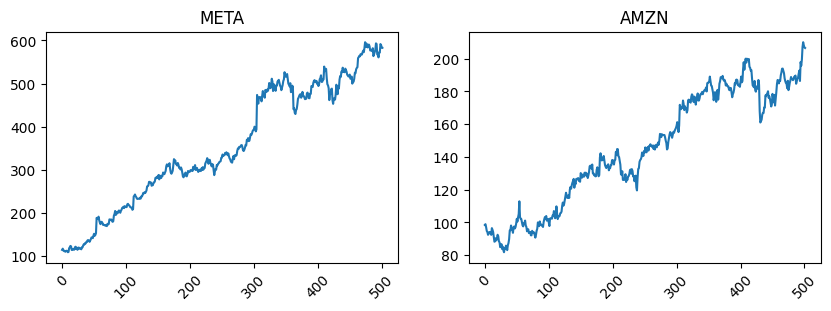

In [86]:
possible_pairs_assets = itertools.combinations(industry_data_dict.keys(),2)
cointegrated_stocks = []

for (stock_A,stock_B) in possible_pairs_assets:
    x = list(industry_data_dict[stock_A]['Close'])
    y = list(industry_data_dict[stock_B]['Close'])
    t_statistic, p_val, critical_p_val = coint(x,y)
    # print(f' t statistic: {np.round(t_statistic, 2)} \n p value: {np.round(p_val,2)} \n critical p values [1%, 5%, 10%] critical_p_val')
    if p_val < 0.05 and t_statistic < critical_p_val[1]: # critical_p_value is an array of 3 relating to 1% 5% 10% critical values for the hypothesis test
        cointegrated_stocks.append((stock_A,stock_B))
number_cointegrated_stocks = len(cointegrated_stocks)
number_possible_combinations = math.comb(len(industry_data_dict.keys()),2)
print(f"Out of {number_possible_combinations} combinations of pairs, {number_cointegrated_stocks} cointegrated pairs were found.")

# pair = cointegrated_stocks[1]
# coint_single_dict = {pair[0]: list(industry_data_dict[pair[0]]['Close']),
#                      pair[1]: list(industry_data_dict[pair[1]]['Close'])}
# plotGraph(coint_single_dict)

for pairs in cointegrated_stocks:
    pair = cointegrated_stocks[cointegrated_stocks.index(pairs)]
    coint_single_dict = {pair[0]: list(industry_data_dict[pair[0]]['Close']),
                     pair[1]: list(industry_data_dict[pair[1]]['Close'])}
    plotGraph(coint_single_dict)

In [87]:
%store cointegrated_stocks industry_data_dict 

Stored 'cointegrated_stocks' (list)
Stored 'industry_data_dict' (dict)
